Code for this post can be found [here](https://github.com/pvonglehn/data-science-concepts/Volcanos.ipynb)  

Poisson processes are used to model the occurences of events over time which occur independently of each other and with a constant rate. For example radioactive decay, emission of photons from a weak source and telephone calls to a customer service center can all be modelled as Poisson processes. 

Poisson process models can be used to estimate useful properties of these systems. For example in planning how many customer service employees to hire it is important to know not just the average number of calls in a day, but also the probability of receiving more X calls in a day so keep the probability of being overwhelmed on any given day acceptably low.   

It has already been established in the volcanology literature that volcanic eruptions can be well modelled as Poisson processes [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5931572/) and that's what we'll do in this notebook.

[1]:Papale P. Global time-size distribution of volcanic eruptions on Earth. Sci Rep. 2018;8(1):6838. Published 2018 May 1. doi:10.1038/s41598-018-25286-y


## Poisson process equations

A Poisson process is a single parameter model. This parameter is the arrival rate $\lambda$ and is equal to the mean number of occurences (known as arrivals) per unit of time.


### Interarrival time
The interarrival time is the time between successive occurrences. The probability density function (PDF) for this is an exponential distribution with parameter lambda, given by the formula below.

$$f_{Y}(y) = \lambda e^{-\lambda y}$$



### Number of occurences per unit time

The PDF for the number of occurences per unit time (k) is given below.

$$P_K(k) = \frac{\lambda^k e^{-\lambda}}{k!}$$






# Getting the data

The data for this study was downloaded from the Smithsonian Institution National Museum of Natural History Global Volcanism Program [database](https://volcano.si.edu/). The data is downloadable in the form of an excel spreadsheet from their website. You can download the reduced data set from my github repo [here]()

Here I have included all confirmed volcanic eruptions between 1950 and 2019 and am treating the start date as the date of occurence.


In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import numpy as np

def load_format_data(file):
    '''read data into dataframe clean and format'''
    
    df = pd.read_excel(file,skiprows=[0],sheet_name="Eruption List")

    # Drop rows without years
    df = df.dropna(subset=['Start Year','Start Month','Start Day'])

    # Select only between 1950 and 2020 (before 1950 not all eruptions have start and months)
    df = df.loc[(df["Start Year"] > 1950)
               & (df["Start Year"] < 2020)
               ]

    # Select only confirmed eruptions
    df = df.loc[df["Eruption Category"] == "Confirmed Eruption"]

    # Convert dates to datetime object
    df["dt"] = pd.to_datetime(df[['Start Year','Start Month','Start Day']]
                               .astype(int)
                               .astype(str)
                               .agg('-'.join, axis=1)
                                  )
    
    # Sort in ascending order
    df = df.sort_values("dt") 
    df = df.reset_index()
    
    columns = ["Eruption Number","dt"]
    
    return df[columns]

In [80]:
file = pathlib.Path().joinpath("data","GVP_Eruption_Results_all.xlsx")

df = load_format_data(file)

save_file = pathlib.Path().joinpath("data","volcanos.csv")
df.to_csv(save_file)

In [59]:
from statsmodels.graphics.tsaplots import plot_acf

def get_interarrival_times(df):
    '''get times between eruptions (in days)'''
    
    Y = (df.iloc[1:]
           .apply(lambda row: row["dt"] - df.iloc[row.name - 1]["dt"],axis=1)
           .dt.days
           .values
        )

    return Y

def plot_autocorrelation(Y):
    '''plot autocorrelation of arrival times'''
    
    fig, ax = plt.subplots(figsize=(8,5))
    _ = plot_acf(np.array(Y),ax=ax)
    ax.set_title("autocorrelation of arrival times",fontsize=16)
    ax.set_xlabel("lag (days)",fontsize=12)
    ax.set_ylabel("correlation coefficient",fontsize=12)
    

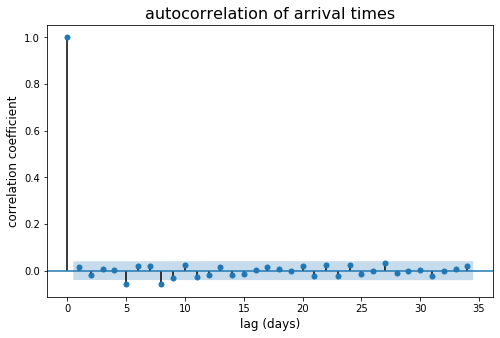

In [61]:
Y = get_interarrival_times(df)

plot_autocorrelation(Y)


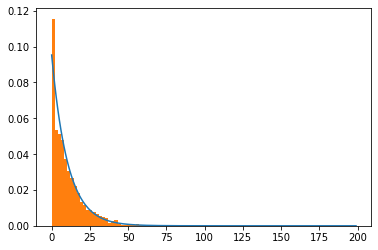

In [70]:
def expon(lambda_,x):
    '''pdf of exponential random variable'''
    
    return lambda_*np.exp(-lambda_*x)

expon = np.vectorize(expon)

fix,ax = plt.subplots()
x = np.arange(0,200)
y = expon(l,x)
ax.plot(x,y)
_ = ax.hist(Y,density=True,bins=40)

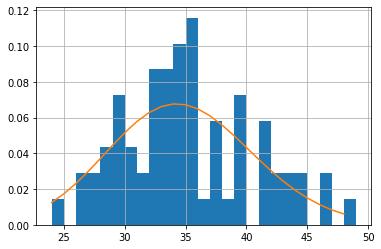

In [78]:
counts = df.groupby(["Start Year"])["Eruption Number"].count().values
max_counts = max(counts)
min_counts = min(counts)
x = np.arange(min_counts,max_counts)
df.groupby(["Start Year"])["Eruption Number"].count().hist(bins=max_counts-min_counts,density=True)
plt.plot(x,poisson(34.768).pmf(x))

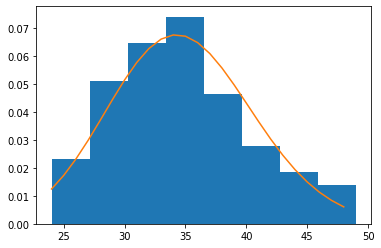

In [81]:
from scipy.stats import poisson
x = np.arange(min_counts,max_counts)
df.groupby(["Start Year"])["Eruption Number"].count().hist(bins=(max_counts-min_counts)//3,density=True,grid=False)
plt.plot(x,poisson(34.768).pmf(x))

In [5]:
from statsmodels.discrete.discrete_model import Poisson 
import statsmodels.api as sm

model = Poisson(endog=counts,exog=np.expand_dims(np.ones_like(counts),axis=1))
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 3.102243
         Iterations 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:                        Poisson   Df Residuals:                       68
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 May 2020   Pseudo R-squ.:                   0.000
Time:                        09:55:21   Log-Likelihood:                -214.05
converged:                       True   LL-Null:                       -214.05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5487      0.020    173.814      0.000       3.509       3.589
==============================================================================
"""

In [153]:
np.exp(3.5487)

34.768089579378085

In [104]:
res.predict([0,1,2,3,4])

array([1.00000000e+00, 4.01884058e+01, 1.61510796e+03, 6.49086141e+04,
       2.60857372e+06])

In [7]:
# max likelihood

In [59]:
from scipy.stats import expon

In [69]:
n = 10000
ts = expon().rvs(n)
n/ts.sum()

0.9988347959622934

In [70]:
def expon(l,x):
    return l*np.exp(-l*x)

# interarrival time